In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

batch_size      = 64
test_batch_size = 1000
log_interval    = 100

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

Let us show some of the training images, for fun.



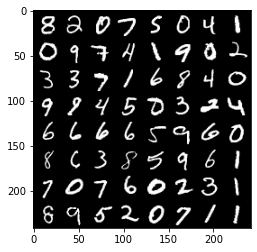

In [3]:
# functions to show an image
def imshow(img):
    #img = img / 0.3081 + 0.1307    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).mean(2), cmap="gray")
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
def log_train(epoch, batch_idx, loss):
    if log_interval and batch_idx % log_interval == 0:
        p_done = 100. * batch_idx / len(train_loader)
        ntotal = len(train_loader.dataset)
        nprocessed = batch_idx * batch_size
        print(f"Train Epoch: {epoch} [{nprocessed: >5}/{ntotal} ({p_done: >2.0f}%)]\tLoss: {loss:.6f}")

In [6]:
def get_lnorm(model, l_norm=2, alpha=0.001):
    return sum(alpha*torch.norm(param, l_norm) ** l_norm for param in model.parameters())

def train(model, optimizer, epoch, reg=None, regularization=None):
    model.train()
    losses = []
    r = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg:
            r = get_lnorm(model, reg)
        loss = F.nll_loss(output, target) + r
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        log_train(epoch, batch_idx, loss)
    return np.mean(losses)

def test(model, reg=None):
    model.eval()
    test_loss = 0
    correct = 0
    r = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if reg:
                r = get_lnorm(model, reg)
            test_loss += F.nll_loss(output, target, reduction='sum').item() + r
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    error = 1 - acc

    if log_interval:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, error

In [7]:
def count_params(model, threshold=1e-4):
    return sum([torch.sum((torch.abs(p.data) < threshold)).item() for p in model.parameters()])

In [8]:
import torch.optim as optim
from time import time

def fit_model(model, Optimizer=optim.Adadelta, epochs=15, regularization=None, lr=1e-3):
    train_loss = []
    test_loss = []
    test_errors = []
    param_counts = []
    start = time()
    model.to(device)

    optimizer = Optimizer(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        loss = train(model, optimizer, epoch, regularization)
        train_loss.append(loss)
        loss, error = test(model, regularization)
        test_loss.append(loss)
        test_errors.append(error)
        param_counts.append(count_params(model))
    print(f'Done training with after {time() - start:.2f} s')

    return model, train_loss, test_loss, test_errors, param_counts

In [9]:
from torch.nn.init import *
import torch.optim as optim

epochs = 10
regularization = {'$L_1$': (1, 'r'),
                  '$L_2$': (2, 'g'),
                  'none': (None, 'b')}

loss_names = {'train_loss': 'Training',
              'test_loss': 'Testing',
              'test_errors': 'Misclassification'}

optimizers = [optim.SGD, optim.Adadelta, optim.Adagrad]

In [ ]:
results = {}
for optimizer in optimizers:
    optimizer_name = str(optimizer).split(".")[-1][:-2]
    print(f"\nTraining with {optimizer_name}")

    optim_results = {}
    for reg_name, (reg, c) in regularization.items():
        t = fit_model(Net(), regularization=reg, epochs=epochs, Optimizer=optimizer)
        model, train_loss, test_loss, test_errors, counts = t
        optim_results[reg_name] = {'model': model,
                                   'train_loss': train_loss,
                                   'test_loss': test_loss,
                                   'test_errors': test_errors,
                                   'nparams': counts}
    results[optimizer_name] = optim_results


Training with SGD
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 9.093578
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 8.953879
Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.816390
Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.666239
Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.523512
Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.373667
Train Epoch: 1 [38400/60000 (64%)]	Loss: 8.186322
Train Epoch: 1 [44800/60000 (75%)]	Loss: 7.898363
Train Epoch: 1 [51200/60000 (85%)]	Loss: 7.696727
Train Epoch: 1 [57600/60000 (96%)]	Loss: 7.431861

Test set: Average loss: 1.5707, Accuracy: 7451/10000 (75%)

Train Epoch: 2 [    0/60000 ( 0%)]	Loss: 7.385434
Train Epoch: 2 [ 6400/60000 (11%)]	Loss: 7.049115
Train Epoch: 2 [12800/60000 (21%)]	Loss: 6.753134
Train Epoch: 2 [19200/60000 (32%)]	Loss: 6.454856
Train Epoch: 2 [25600/60000 (43%)]	Loss: 6.309461
Train Epoch: 2 [32000/60000 (53%)]	Loss: 6.024403
Train Epoch: 2 [38400/60000 (64%)]	Loss: 5.918644
Train Epoch: 2 [44800/60000 (75%)]	Loss: 5.787953
Train Epoch: 2 [5120

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.418399
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.393644
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.455229
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.414855

Test set: Average loss: 0.3252, Accuracy: 9084/10000 (91%)

Train Epoch: 6 [    0/60000 ( 0%)]	Loss: 0.416106
Train Epoch: 6 [ 6400/60000 (11%)]	Loss: 0.261004
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.363880
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.598240
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.358742
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.604993
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.555791
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.339680
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.430349
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.335001

Test set: Average loss: 0.3063, Accuracy: 9121/10000 (91%)

Train Epoch: 7 [    0/60000 ( 0%)]	Loss: 0.401477
Train Epoch: 7 [ 6400/60000 (11%)]	Loss: 0.567583
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.262481
Train Epoch: 7 [19200/60000 

Train Epoch: 10 [ 6400/60000 (11%)]	Loss: 0.204398
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.298415
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.354777
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.326800
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.263356
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.324164
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.345034
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.382965
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.257283

Test set: Average loss: 0.2614, Accuracy: 9232/10000 (92%)

Done training with after 87.40 s

Training with Adadelta
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 9.120696
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 8.986214
Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.858091
Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.737473
Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.612392
Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.498916
Train Epoch: 1 [38400/60000 (64%)]	Loss: 8.371674
Train Epoch: 1 [44800/60000 (75%)]	Loss: 8.258307
Train Epoch: 1 [51200/6

Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.531618
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.478915
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.503521
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.641331

Test set: Average loss: 0.4722, Accuracy: 8773/10000 (88%)

Train Epoch: 5 [    0/60000 ( 0%)]	Loss: 0.505975
Train Epoch: 5 [ 6400/60000 (11%)]	Loss: 0.503016
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.618017
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.574590
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.735412
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.612925
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.486732
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.797242
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.483217
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.594178

Test set: Average loss: 0.4092, Accuracy: 8903/10000 (89%)

Train Epoch: 6 [    0/60000 ( 0%)]	Loss: 0.382179
Train Epoch: 6 [ 6400/60000 (11%)]	Loss: 0.440699
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.331655
Train Epoch: 6 [19200/60000 

Train Epoch: 9 [ 6400/60000 (11%)]	Loss: 0.400559
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.484849
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.353827
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.291102
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.396572
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.238073
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.239211
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.411285
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.393482

Test set: Average loss: 0.3375, Accuracy: 9055/10000 (91%)

Train Epoch: 10 [    0/60000 ( 0%)]	Loss: 0.353861
Train Epoch: 10 [ 6400/60000 (11%)]	Loss: 0.262787
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.318533
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.378920
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.373825
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.194669
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.212268
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.498851
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.329089
Train Epoch: 10 [57600/60000 (

Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.225817
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.282359
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.277640
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.228894

Test set: Average loss: 0.1729, Accuracy: 9502/10000 (95%)

Train Epoch: 4 [    0/60000 ( 0%)]	Loss: 0.177614
Train Epoch: 4 [ 6400/60000 (11%)]	Loss: 0.238286
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.191085
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.210807
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.232955
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.242045
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.172653
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.227028
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.234181
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.165686

Test set: Average loss: 0.1530, Accuracy: 9574/10000 (96%)

Train Epoch: 5 [    0/60000 ( 0%)]	Loss: 0.302804
Train Epoch: 5 [ 6400/60000 (11%)]	Loss: 0.167924
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.223595
Train Epoch: 5 [19200/60000 

Train Epoch: 8 [ 6400/60000 (11%)]	Loss: 0.059645


In [ ]:
for optimizer in optimizers:
    optimizer_name = str(optimizer).split(".")[-1][:-2]
    optim_results = results[optimizer_name]
    x = np.arange(epochs)+1
    for reg_name, (reg, c) in regularization.items():
        result = optim_results[reg_name]
        plt.plot(x, result["train_loss"], f"-{c}", label=f"{reg_name}")
    plt.title(f"Train reguralization with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("NLL")
    plt.legend()
    plt.savefig(f"img/train_loss-{optimizer_name}.pdf")
    plt.show()

    for reg_name, (reg, c) in regularization.items():
        result = optim_results[reg_name]
        plt.plot(x, result["test_loss"],  f"-{c}",  label=f"{reg_name}")
    plt.title(f"Test reguralization with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("NLL")
    plt.legend()
    plt.savefig(f"img/test_loss-{optimizer_name}.pdf")
    plt.show()

    for reg_name, (reg, c) in regularization.items():
        result = optim_results[reg_name]
        plt.plot(x, result["test_errors"],  f"-{c}",  label=f"{reg_name}")
    plt.title(f"Test accuracy with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("misclassification rate")
    plt.legend()
    plt.savefig(f"img/accuracy-{optimizer_name}.pdf")
    plt.show()


In [ ]:
for optimizer in optimizers:
    optimizer_name = str(optimizer).split(".")[-1][:-2]
    optim_results = results[optimizer_name]
    x = np.arange(epochs)+1
    reg_name = '$L_1$'
    plt.plot(x, result["nparams"], label=f"{optimizer_name}")
plt.title(f"Params / epoch")
plt.xlabel("epochs")
plt.ylabel("# Params")
plt.savefig(f"img/params.pdf")
plt.show()